### Survival analysis

In [1]:
"""
    Weibull Time-To-Event loss functions
"""

from math import log
import torch
from torch import nn

EPS = 1e-35

def weibull_loglik_discrete(y, u, a, b):
    hazard0 = torch.pow((y + EPS) / a, b)
    hazard1 = torch.pow((y + 1) / a, b)
    return u * torch.log(torch.exp(hazard1 - hazard0) - (1.0 - EPS)) - hazard1

def weibull_loglik_continuous(y, u, a, b):
    ya = (y + EPS) / a
    return u * (torch.log(b) + b * torch.log(ya)) - torch.pow(ya, b)

def weibull_loss_function(y_true,
                          y_pred,
                          clip_prob=1e-5,
                          kind="discrete"
                        ):

    y, u = torch.unbind(y_true, dim=-1)
    a, b = torch.unbind(y_pred, dim=-1)

    if kind == 'discrete':
        log_likelihoods = weibull_loglik_discrete(y, u, a, b)
    else:
        logl_ikelihoods = weibull_loglik_continuous(y, u, a, b)
    
    if clip_prob is not None:
        log_likelihoods = torch.clamp(log_likelihoods, 
            log(clip_prob), log(1 - clip_prob))
        
    return -1.0 * log_likelihoods


class WeibullActivation(nn.Module):
    def __init__(self, init_alpha=1.0, max_beta=5.0):
        super().__init__()
        self.init_alpha = torch.tensor(init_alpha)
        self.max_beta = torch.tensor(max_beta)     

    def forward(self, x):
        
        alpha, beta = torch.unbind(x, dim=-1)
        alpha = self.init_alpha * torch.exp(alpha)

        if self.max_beta > 1.05:
            shift = torch.log(self.max_beta - 1.0)
            beta = beta - shift

        beta = self.max_beta * torch.clamp(
            torch.sigmoid(beta), min=EPS, max=1.0 - EPS
        )
        
        return torch.stack([alpha, beta], axis=-1)

In [2]:
class WTTERNN(nn.Module):
    def __init__(self, 
                 n_features=1,
                 hidden_size=20,
                 dropout=0.05,
                 num_layers=1,
                 init_alpha=1.0,
                 max_beta_value=4.0
                ):
        super().__init__()
        self.rnn = nn.GRU(
            input_size=n_features,
            num_layers=num_layers,
            hidden_size=hidden_size,
            dropout= dropout if num_layers > 1 else 0,
            batch_first=True,
        )
        self.rnn_activation = nn.Tanh()
        self.fc_out = nn.Linear(hidden_size, 2)
        self.w_activation = WeibullActivation(init_alpha, max_beta_value)
    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.rnn_activation(x)
        x = x.mean(dim=1)
        x = self.fc_out(x)
        x = self.w_activation(x)
        return x

In [3]:
%matplotlib inline
import sys
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

np.random.seed(11)
torch.manual_seed(11)

In [4]:
id_col = 'unit_number'
time_col = 'time'
feature_cols = [ 'op_setting_1', 'op_setting_2', 'op_setting_3'] + ['sensor_measurement_{}'.format(x) for x in range(1,22)]
column_names = [id_col, time_col] + feature_cols

In [5]:
np.set_printoptions(suppress=True, threshold=10000)
import pandas as pd

train_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/train.csv', header=None, names=column_names)
test_x_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/test_x.csv', header=None, names=column_names)
test_y_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/test_y.csv', header=None, names=['T'])

In [6]:
test_x_orig.set_index(['unit_number', 'time'], verify_integrity=True)

op_setting_1  op_setting_2  op_setting_3  \
unit_number time                                             
1           1           0.0023        0.0003         100.0   
            2          -0.0027       -0.0003         100.0   
            3           0.0003        0.0001         100.0   
            4           0.0042        0.0000         100.0   
            5           0.0014        0.0000         100.0   
...                        ...           ...           ...   
100         194         0.0049        0.0000         100.0   
            195        -0.0011       -0.0001         100.0   
            196        -0.0006       -0.0003         100.0   
            197        -0.0038        0.0001         100.0   
            198         0.0013        0.0003         100.0   

                  sensor_measurement_1  sensor_measurement_2  \
unit_number time                                               
1           1                   518.67                643.02   
            2                   518.67                641.71   
            3                   518.67                642.46   
            4                   518.67                642.44   
            5                   518.67                642.51   
...                                ...                   ...   
100         194                 518.67                643.24   
            195                 518.67                643.22   
            196                 518.67                643.44   
            197                 518.67                643.26   
            198                 518.67                642.95   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
1           1                  1585.29               1398.21   
            2                  1588.45               1395.42   
            3                  1586.94               1401.34   
            4                  1584.12               1406.42   
            5                  1587.19               1401.92   
...                                ...                   ...   
100         194                1599.45               1415.79   
            195                1595.69               1422.05   
            196                1593.15               1406.82   
            197                1594.99               1419.36   
            198                1601.62               1424.99   

                  sensor_measurement_5  sensor_measurement_6  \
unit_number time                                               
1           1                    14.62                 21.61   
            2                    14.62                 21.61   
            3                    14.62                 21.61   
            4                    14.62                 21.61   
            5                    14.62                 21.61   
...                                ...                   ...   
100         194                  14.62                 21.61   
            195                  14.62                 21.61   
            196                  14.62                 21.61   
            197                  14.62                 21.61   
            198                  14.62                 21.61   

                  sensor_measurement_7  ...  sensor_measurement_12  \
unit_number time                        ...                          
1           1                   553.90  ...                 521.72   
            2                   554.85  ...                 522.16   
            3                   554.11  ...                 521.97   
            4                   554.07  ...                 521.38   
            5                   554.16  ...                 522.15   
...                                ...  ...                    ...   
100         194                 553.41  ...                 520.69   
            195                 553.22  ...                 521.05   
            

In [7]:
train_orig.set_index(['unit_number', 'time'], verify_integrity=True)

op_setting_1  op_setting_2  op_setting_3  \
unit_number time                                             
1           1          -0.0007       -0.0004         100.0   
            2           0.0019       -0.0003         100.0   
            3          -0.0043        0.0003         100.0   
            4           0.0007        0.0000         100.0   
            5          -0.0019       -0.0002         100.0   
...                        ...           ...           ...   
100         196        -0.0004       -0.0003         100.0   
            197        -0.0016       -0.0005         100.0   
            198         0.0004        0.0000         100.0   
            199        -0.0011        0.0003         100.0   
            200        -0.0032       -0.0005         100.0   

                  sensor_measurement_1  sensor_measurement_2  \
unit_number time                                               
1           1                   518.67                641.82   
            2                   518.67                642.15   
            3                   518.67                642.35   
            4                   518.67                642.35   
            5                   518.67                642.37   
...                                ...                   ...   
100         196                 518.67                643.49   
            197                 518.67                643.54   
            198                 518.67                643.42   
            199                 518.67                643.23   
            200                 518.67                643.85   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
1           1                  1589.70               1400.60   
            2                  1591.82               1403.14   
            3                  1587.99               1404.20   
            4                  1582.79               1401.87   
            5                  1582.85               1406.22   
...                                ...                   ...   
100         196                1597.98               1428.63   
            197                1604.50               1433.58   
            198                1602.46               1428.18   
            199                1605.26               1426.53   
            200                1600.38               1432.14   

                  sensor_measurement_5  sensor_measurement_6  \
unit_number time                                               
1           1                    14.62                 21.61   
            2                    14.62                 21.61   
            3                    14.62                 21.61   
            4                    14.62                 21.61   
            5                    14.62                 21.61   
...                                ...                   ...   
100         196                  14.62                 21.61   
            197                  14.62                 21.61   
            198                  14.62                 21.61   
            199                  14.62                 21.61   
            200                  14.62                 21.61   

                  sensor_measurement_7  ...  sensor_measurement_12  \
unit_number time                        ...                          
1           1                   554.36  ...                 521.66   
            2                   553.75  ...                 522.28   
            3                   554.26  ...                 522.42   
            4                   554.45  ...                 522.86   
            5                   554.00  ...                 522.19   
...                                ...  ...                    ...   
100         196                 551.43  ...                 519.49   
            197                 550.86  ...                 519.68   
            

In [8]:
from sklearn import pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Combine the X values to normalize them, 
all_data_orig = pd.concat([train_orig, test_x_orig])
# all_data = all_data[feature_cols]
# all_data[feature_cols] = normalize(all_data[feature_cols].values)

scaler=pipeline.Pipeline(steps=[
#     ('z-scale', StandardScaler()),
     ('minmax', MinMaxScaler(feature_range=(-1, 1))),
     ('remove_constant', VarianceThreshold())
])

all_data = all_data_orig.copy()
all_data = np.concatenate([all_data[['unit_number', 'time']], scaler.fit_transform(all_data[feature_cols])], axis=1)

In [9]:
# then split them back out
train = all_data[0:train_orig.shape[0], :]
test = all_data[train_orig.shape[0]:, :]

# Make engine numbers and days zero-indexed, for everybody's sanity
train[:, 0:2] -= 1
test[:, 0:2] -= 1

In [10]:
import tqdm
from tqdm import tqdm

# TODO: replace using wtte data pipeline routine
def build_data(engine, time, x, max_time, is_test, mask_value):
    # y[0] will be days remaining, y[1] will be event indicator, always 1 for this data
    out_y = []
    
    # number of features
    d = x.shape[1]

    # A full history of sensor readings to date for each x
    out_x = []

    n_engines=100
    for i in tqdm(range(n_engines)):
        # When did the engine fail? (Last day + 1 for train data, irrelevant for test.)
        max_engine_time = int(np.max(time[engine == i])) + 1

        if is_test:
            start = max_engine_time - 1
        else:
            start = 0

        this_x = []

        for j in range(start, max_engine_time):
            engine_x = x[engine == i]

            out_y.append(np.array((max_engine_time - j, 1), ndmin=2))

            xtemp = np.zeros((1, max_time, d))
            xtemp += mask_value
            
            xtemp[:, max_time-min(j, 99)-1:max_time, :] = engine_x[max(0, j-max_time+1):j+1, :]
            this_x.append(xtemp)
            
        this_x = np.concatenate(this_x)
        out_x.append(this_x)
        
    out_x = np.concatenate(out_x)
    out_y = np.concatenate(out_y)
    return out_x, out_y

In [11]:
# Configurable observation look-back period for each engine/day
max_time = 100
mask_value = -99

train_x, train_y = build_data(engine=train[:, 0], time=train[:, 1], x=train[:, 2:], max_time=max_time, is_test=False, mask_value=mask_value)
test_x,_ = build_data(engine=test[:, 0], time=test[:, 1], x=test[:, 2:], max_time=max_time, is_test=True, mask_value=mask_value)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 15843.11it/s]


In [12]:
train_x.shape

(20631, 100, 17)

In [13]:
# always observed in our case
test_y = test_y_orig.copy()
test_y['E'] = 1

In [14]:
tte_mean_train = np.nanmean(train_y[:,0])
mean_u = np.nanmean(train_y[:,1])

# Initialization value for alpha-bias 
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
init_alpha = init_alpha/mean_u
print('tte_mean_train', tte_mean_train, 'init_alpha: ',init_alpha,'mean uncensored train: ',mean_u)

tte_mean_train 108.80786195530997 init_alpha:  109.30709957832491 mean uncensored train:  1.0


In [15]:
from tqdm import tqdm

In [16]:
device = torch.device("cpu")

epochs = 8
train_data = TensorDataset(torch.tensor(train_x).float(), torch.tensor(train_y).float())

batch_size = 256

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = WTTERNN(n_features= 17, init_alpha=init_alpha, max_beta_value=100.0)
model.to(device)
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)

pbar = tqdm(range(epochs))

for epoch in pbar:
    
    running_loss = 0
    
    for (X, y) in train_loader:
        
        optimizer.zero_grad()
        out = model(X.to(device))
        
        if torch.isnan(out).any():
            break
        
        loss = weibull_loss_function(y, out).mean()
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    pbar.set_postfix({"loss": running_loss/len(train_loader)})

100%|████████████████████████████████████| 8/8 [01:23<00:00, 10.44s/it, loss=4.78]


In [17]:
model.eval()
predicted = model(torch.tensor(test_x).float()).cpu().detach().numpy()

In [18]:
test_predict = np.resize(predicted, (100, 2))

In [19]:
test_result = np.concatenate((test_y, test_predict), axis=1)

In [20]:
test_results_df = pd.DataFrame(test_result, columns=['T', 'E', 'alpha', 'beta'])
test_results_df['unit_number'] = np.arange(1, test_results_df.shape[0]+1)


In [21]:
test_results_df

,T,E,alpha,beta,unit_number
0,112.0,1.0,203.762741,4.041731,1
1,98.0,1.0,170.433411,3.478853,2
2,69.0,1.0,85.403549,3.400831,3
3,82.0,1.0,88.393333,2.975938,4
4,91.0,1.0,97.505974,3.441105,5
...,...,...,...,...,...
95,137.0,1.0,136.265808,3.337926,96
96,82.0,1.0,117.052345,2.744944,97
97,59.0,1.0,78.803841,3.279860,98
98,117.0,1.0,143.215134,3.403321,99


In [22]:
import seaborn as sns

In [23]:
def weibull_pdf(alpha, beta, t):
    return (beta/alpha) * (t/alpha)**(beta-1)*np.exp(- (t/alpha)**beta)

def weibull_median(alpha, beta):
    return alpha*(-np.log(.5))**(1/beta)

def weibull_mean(alpha, beta):
    return alpha * math.gamma(1 + 1/beta)

def weibull_mode(alpha, beta):
    assert np.all(beta > 1)
    return alpha * ((beta-1)/beta)**(1/beta)

alpha 99.5379388332367 beta 2.9926265966892243


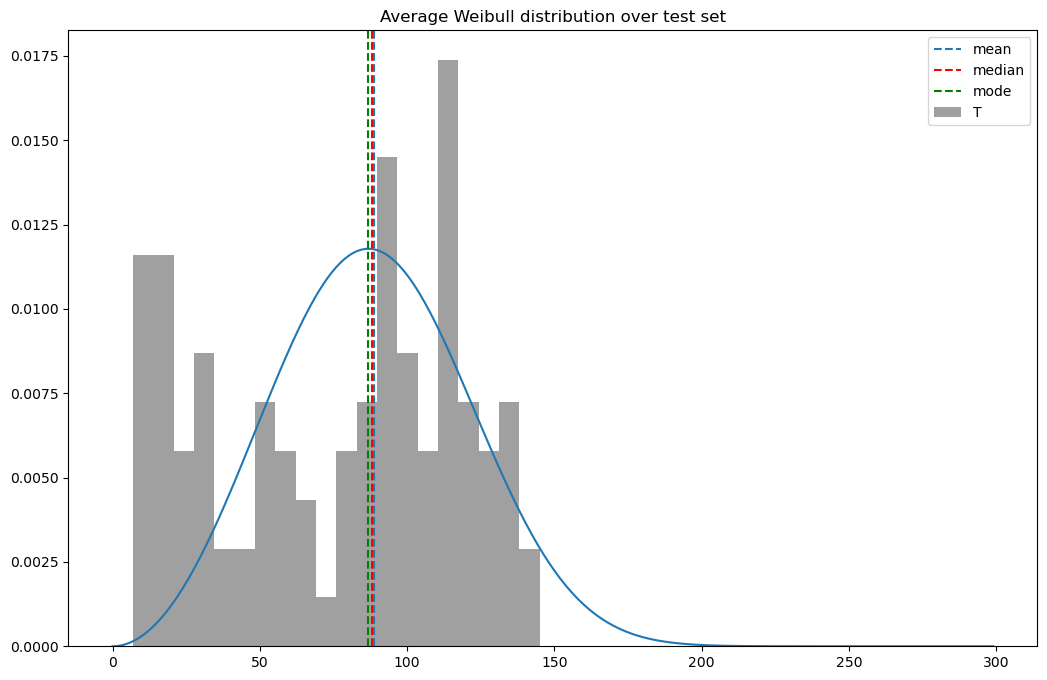

In [24]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
t=np.arange(0,300)
alpha = test_results_df['alpha'].mean()
beta = test_results_df['beta'].mean()

plt.plot(t, weibull_pdf(alpha,beta, t))
mu = weibull_mean(alpha, beta)
median =weibull_median(alpha, beta)
mode = weibull_mode(alpha, beta)
plt.axvline(mu, ls='--', label='mean')
plt.axvline(median, ls='--', color='red', label='median')
plt.axvline(mode, ls='--', color='green', label='mode')
n, bins, patches = plt.hist(test_results_df['T'], 20, density=True, facecolor='grey', alpha=0.75, label='T')
plt.legend()

plt.gcf().set_size_inches(12.5, 8)
plt.title('Average Weibull distribution over test set')
print('alpha', alpha, 'beta', beta)

In [33]:
def plot_weibull_predictions(results_df):

    fig, axarr = plt.subplots(3, figsize=(20,30))

    t=np.arange(0,400)

    palette = sns.color_palette("RdBu_r", results_df.shape[0] + 1)
    color_dict = dict(enumerate(palette))

    for i, row in enumerate(results_df.iterrows()):
        alpha=row[1]['alpha']
        beta = row[1]['beta']
        T = row[1]['T']
        label = 'a={} b={}'.format(alpha, beta)

        color = color_dict[i]
        ax= axarr[0]
        mode = weibull_mode(alpha, beta)
        y_max = weibull_pdf(alpha, beta, mode)    

        ax.plot(t, weibull_pdf(alpha, beta, t), color=color, label=label)
        ax.scatter(T, weibull_pdf(alpha,beta, T), color=color, s=100)
        ax.vlines(mode, ymin=0, ymax=y_max, colors=color, linestyles='--')

        ax.set_title('Weibull distributions')
    
    ax=axarr[1]
    
    median_predictions = weibull_median(results_df['alpha'], results_df['beta'])
    mean_predictions = results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
    mode_predictions = weibull_mode(results_df['alpha'], results_df['beta'])

    ax.scatter(x=results_df['T'], y=mode_predictions, label='m_prediction')
    ax.set_xlabel('True time')
    ax.set_ylabel('Pred time')
    ax.set_title('MAP prediction Vs. true')
    

    ax.legend()
    
    ax=axarr[2]
    sns.histplot(results_df['T'] - mode_predictions, kde=True, ax=ax)
    ax.set_title('Error')

    plt.show()


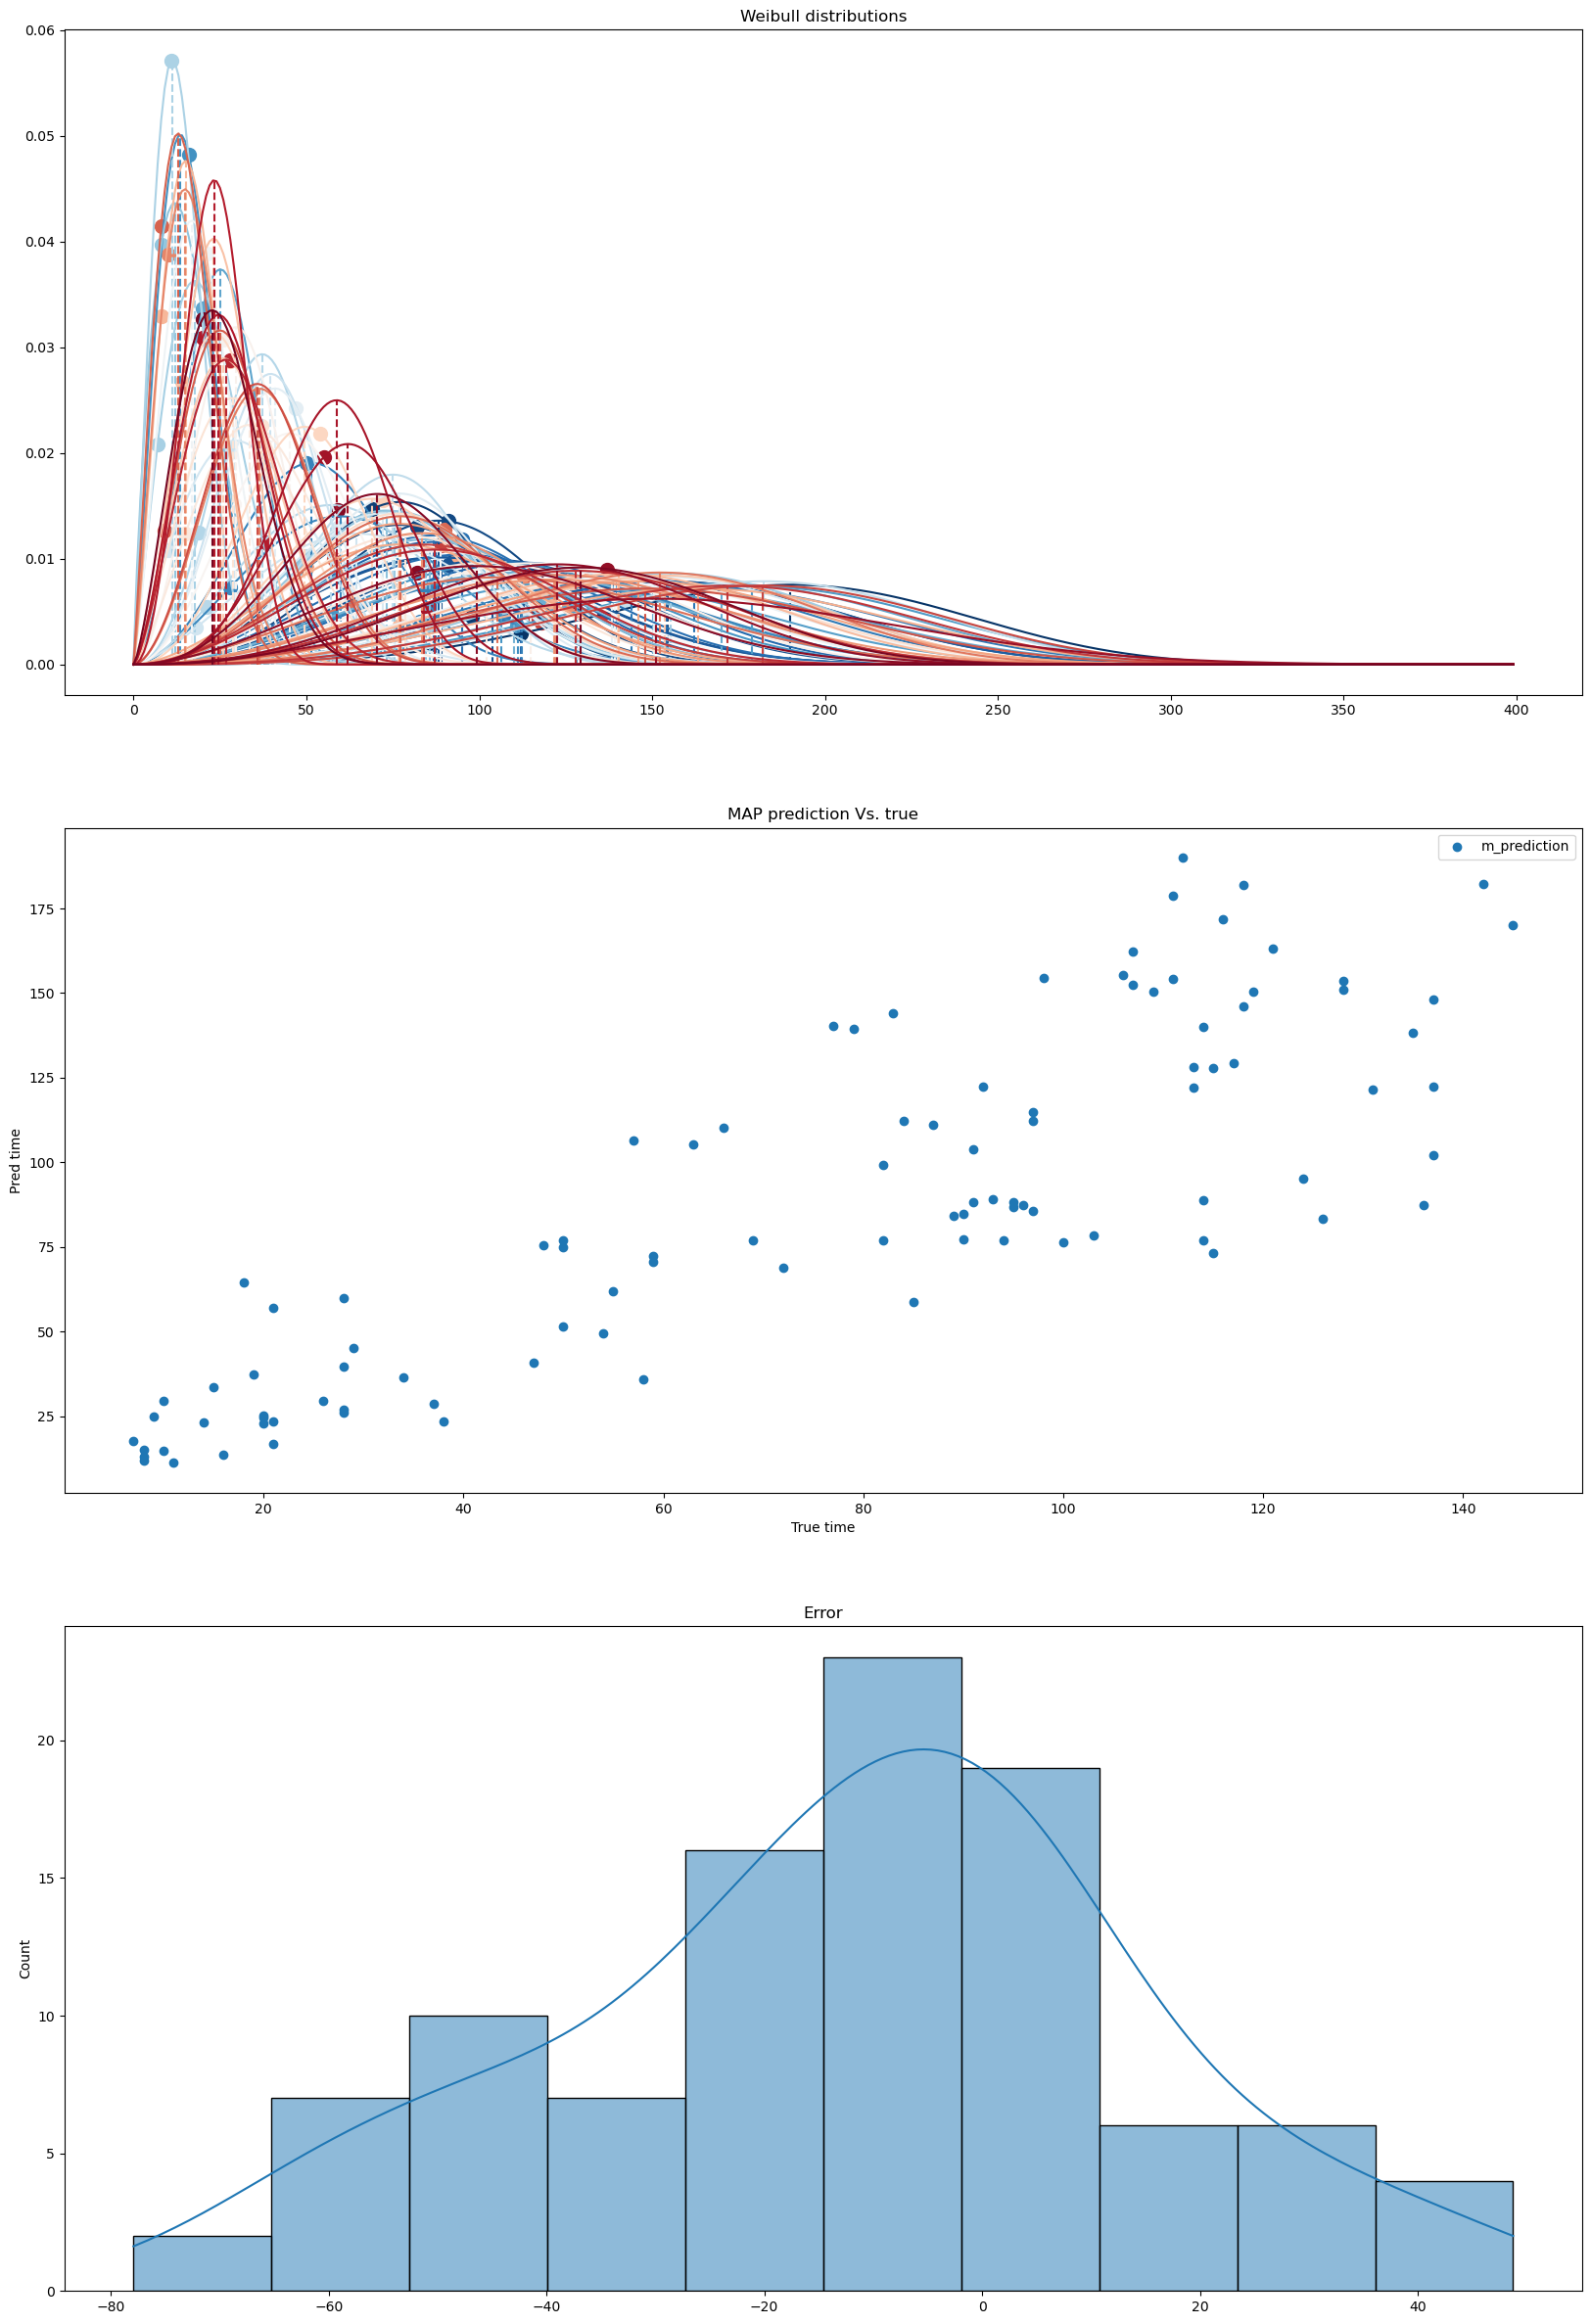

In [34]:
plot_weibull_predictions(results_df=test_results_df)